In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Exploritory data analysis of Macro Trends

In [2]:
dataset = pandas.read_csv('EVCarsHistorical.csv')
dataset = dataset.drop(columns=['category','mode','unit','parameter'])

In [3]:
def region_specific(region):
    bev = dataset.loc[(dataset['region'] == region) & 
                    (dataset['powertrain'] == 'BEV')]
    phev = dataset.loc[(dataset['region'] == region) & 
                    (dataset['powertrain'] == 'PHEV')]

    bev_d = bev['value']
    phev_d = phev['value']
    years = bev['year']
    return bev_d,phev_d,years

In [4]:
regions = ['World','Rest of the world','USA','China','Brazil','India']

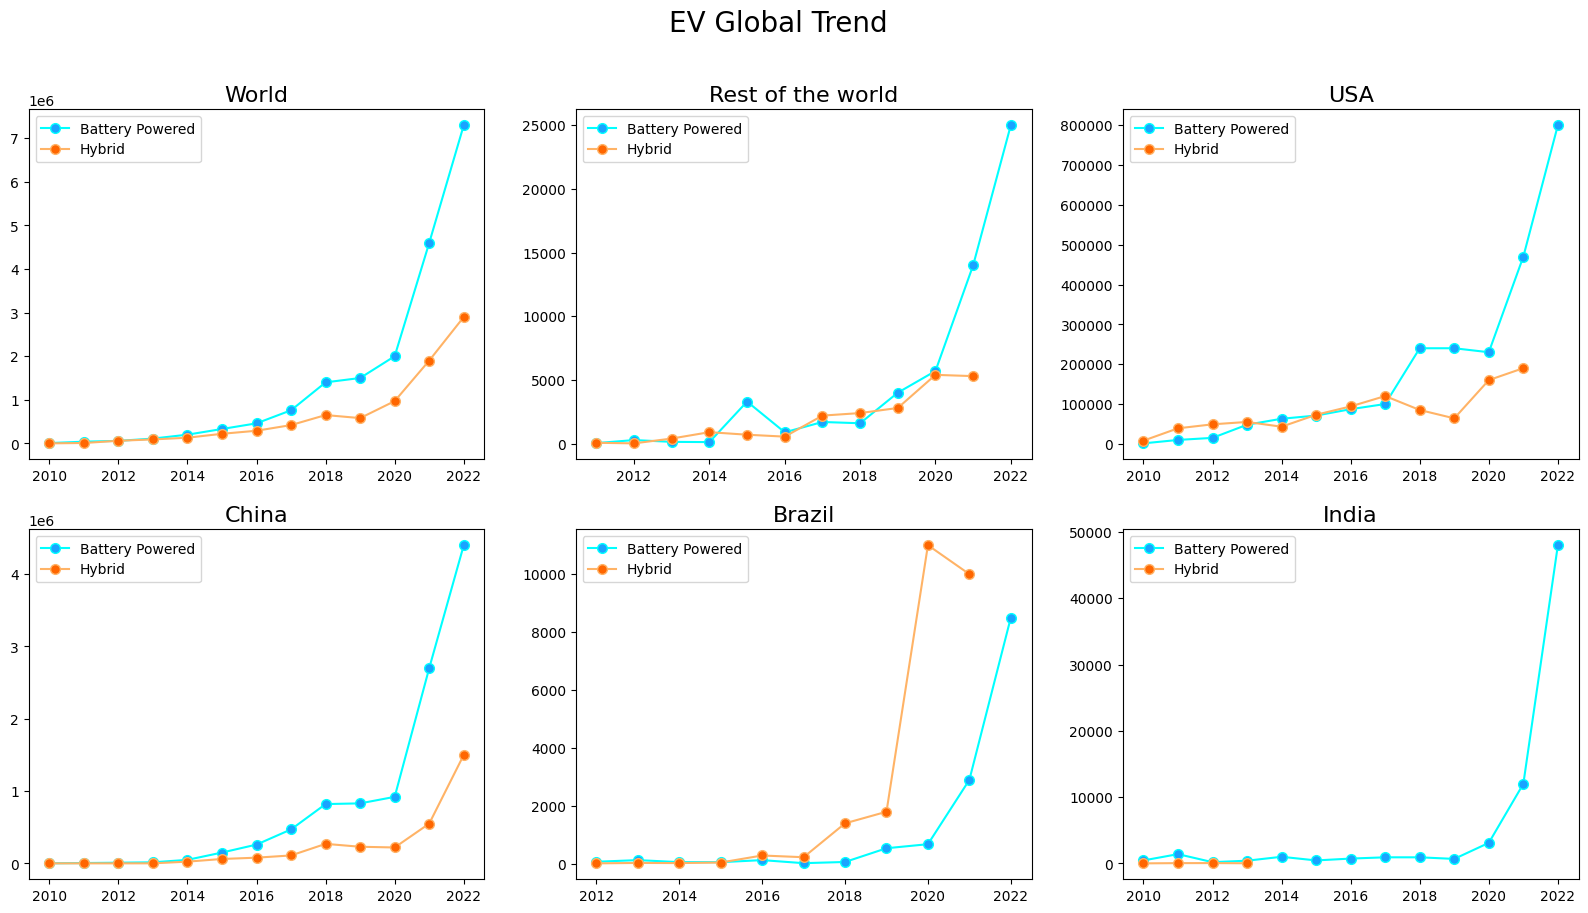

In [5]:
plt.figure(figsize=(20,10))
for i,region in enumerate(regions):
    re_b,re_p,re_y = region_specific(region)
    plt.subplot(2,3,i+1)
    plt.plot(re_y,re_b,marker='o',markersize=7,color='#00ffff',markerfacecolor='#1aa3ff',label='Battery Powered')
    plt.plot(re_y[:len(re_p)],re_p,marker='o',markersize=7,color='#ffb366',markerfacecolor='#ff6600',label='Hybrid')
    plt.title(region,fontdict={'fontsize':16})
    plt.legend()

plt.suptitle('EV Global Trend',fontsize=20)
plt.show()

# Understanding India's Car Market

### Data loading and Cleaning

In [116]:
cars_data = pandas.read_csv('cars_ds_final.csv')

In [117]:
top_consumer_features = ['Make','Ex-Showroom_Price','Displacement','Cylinders',
                         'Fuel_Tank_Capacity','Fuel_Type','City_Mileage','Height',
                         'Length','Width','Gears','Power','Torque']

In [118]:
clean_dataset = cars_data[top_consumer_features]
columns_mode = {i:clean_dataset[i].mode()[0] for i in clean_dataset.columns}
clean_dataset = clean_dataset.fillna(value=columns_mode)

In [119]:
splitable = ['Fuel_Tank_Capacity','Displacement','Height','Length','Width',]

for i in splitable:
    clean_dataset[i] = clean_dataset[i].apply(lambda x : float(x.split()[0]))

def gear_cleaner(x):
    if len(x) == 1:
        return int(x)
    else:
        if x == '7 Dual Clutch':
            return 7
        else:
            return 1
            
def milage_cleaner(x):
    mid = x.split()[0]
    if mid[0] == '?':
        return float(mid[1::])
    else:
        try:
            return float(mid)
        except:
            return float(12.5)

def pw_n_tq_cleaner(x):
    mid = x.split('@')[0]
    try:
        return float(mid[0:-2])
    except:
        return float(50)

def price_cleaner(x):
    mid = "".join(x.split()[1].split(','))
    price = 0
    for i in range(len(mid)):
        price += int(mid[i]) * (10**(len(mid)-i-1))
    return price

clean_dataset['City_Mileage'] = clean_dataset['City_Mileage'].apply(milage_cleaner)
clean_dataset['Power'] = clean_dataset['Power'].apply(pw_n_tq_cleaner)
clean_dataset['Torque'] = clean_dataset['Torque'].apply(pw_n_tq_cleaner)
clean_dataset['Gears'] = clean_dataset['Gears'].apply(gear_cleaner)
clean_dataset['Ex-Showroom_Price'] = clean_dataset['Ex-Showroom_Price'].apply(price_cleaner)

clean_dataset['Make'] = clean_dataset['Make'].map(clean_dataset['Make'].value_counts())
clean_dataset['Fuel_Type'] = clean_dataset['Fuel_Type'].map(clean_dataset['Fuel_Type'].value_counts())

#feature eng
clean_dataset['Space'] = clean_dataset['Height'] * clean_dataset['Length'] * clean_dataset['Width'] / 10e+09

clean_dataset = clean_dataset.drop(['Height','Length','Width'],axis=1)

### Car Segmentation on Basis of Features (Clustering)

In [120]:
X = clean_dataset.drop(['Ex-Showroom_Price'],axis=1)
std_scalar = StandardScaler()
scaled_dataset = std_scalar.fit_transform(X)

In [121]:
km = KMeans(n_clusters=5)
km.fit(scaled_dataset)

/home/ashish/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5)

## Visualizing Clustuers

In [176]:
# Adding group to dataset
clean_dataset['Group'] = km.labels_

In [122]:
# Dimensionality reduction for Visualization
pca = PCA(n_components=3) 
decomposed = pca.fit_transform(scaled_dataset)

In [126]:
np.unique(km.labels_,return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([144, 415, 665,   1,  51]))

In [175]:
datapoints = np.concatenate((decomposed[km.labels_ == 0][:50],
                             decomposed[km.labels_ == 1][:50],
                             decomposed[km.labels_ == 2][:50],
                             decomposed[km.labels_ == 4][:50]),axis=0)
lbl = np.array([0]*50+[1]*50+[2]*50+[3]*50,dtype=np.float32)

cluster_centers = pca.transform(km.cluster_centers_)

In [188]:
def calculate_trimmed_mean(array):
    pivot = round(0.1*len(array))
    mean = np.mean(array[pivot+1:len(array)-pivot-1])
    if mean > 0:
        return mean
    else:
        return 0

cluster_mean_price = []
for i in [0,1,2,3,4]:
    cluster_mean_price.append(calculate_trimmed_mean(clean_dataset[clean_dataset['Group'] == i]['Ex-Showroom_Price']))

In [189]:
x = datapoints[:,1]
y = datapoints[:,0]
z = datapoints[:,2]

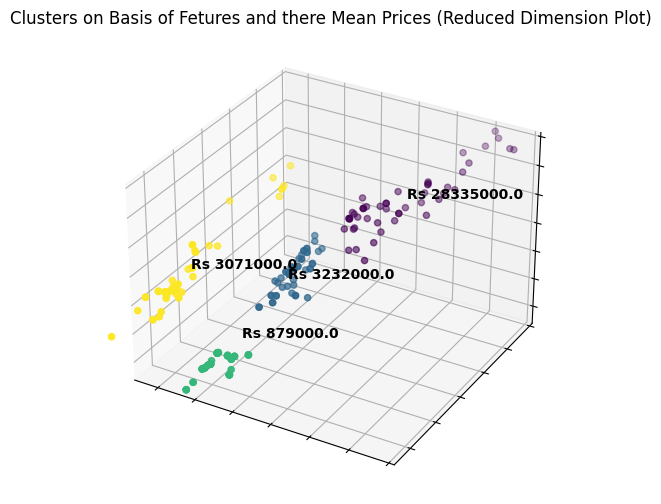

In [204]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(x,y,z,c=lbl)

for cord,price in zip(cluster_centers,cluster_mean_price):
    ax.text(cord[1],cord[0],cord[2],f'Rs {np.round(price,-3)}',fontsize=10,weight='bold')

ax.set_zlim(-5,8)
ax.set_ylim(-1.5,4)
ax.set_xlim(-5,8)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.title('Clusters on Basis of Fetures and there Mean Prices (Reduced Dimension Plot)')
plt.show()

In [214]:
dict = {'Price':[],'CC':[],'Cylinders':[],'Tank':[],'Mileage':[],'Power':[]}
for i in range(0,5):
    mid = clean_dataset[clean_dataset['Group'] == i].apply(calculate_trimmed_mean)
    dict['Price'].append(np.round(mid['Ex-Showroom_Price'],-3))
    dict['CC'].append(np.round(mid['Displacement']))
    dict['Cylinders'].append(np.round(mid['Cylinders']))
    dict['Tank'].append(np.round(mid['Fuel_Tank_Capacity']))
    dict['Mileage'].append(np.round(mid['City_Mileage']))
    dict['Power'].append(np.round(mid['Power']))

In [219]:
group_df = pandas.DataFrame(dict)
group_df = group_df.drop(3)

In [220]:
group_df

,Price,CC,Cylinders,Tank,Mileage,Power
0,28335000.0,4312.0,8.0,79.0,9.0,382.0
1,3232000.0,2029.0,4.0,59.0,12.0,140.0
2,879000.0,1307.0,4.0,42.0,15.0,85.0
4,3071000.0,1340.0,4.0,46.0,23.0,89.0
